In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torch.optim as optim
import common_utils as utils
import wandb
from collections import defaultdict
import torch_pruning as tp
import gc
import matplotlib.pyplot as plt
import pickle
print(utils.device)

cuda


In [2]:
transform = transforms.Compose(
    [
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])


trainset = torchvision.datasets.FER2013(root='./', split="train",
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.FER2013(root='./', split="test",
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=8)

In [ ]:
def compute_sparsity(model):
    for name, param in model.named_parameters():
        print(
            "Sparsity in {0}: {1:.2f}%".format(name,
                100. * float(torch.sum(param == 0))
                / float(param.nelement())
            ), "\nParam Element Count: {0}\n".format(param.nelement())
        )

In [6]:
print("CUDA Reserved Memory: ", torch.cuda.memory_reserved())
layer_sensitivity = defaultdict(list)
example_inputs = torch.randn(1, 1, 96, 96).to(utils.device)
imp = tp.importance.GroupMagnitudeImportance(p=2) 

def get_prunable_modules(model):
    prunable_modules = []
    for name, module in model.named_children():
        if (isinstance(module, nn.MaxPool2d) or (isinstance(module, nn.Linear) and module.out_features == 7)):
            continue
        else:
            prunable_modules.append((name, module))
    return prunable_modules
pruned_model = utils.BaseModel()
num_prunable_params = len(get_prunable_modules(pruned_model))

for param_ind in range(num_prunable_params):
    for i in range(10, 100, 10):
        print("CUDA Reserved Memory: ", torch.cuda.memory_reserved())
        sparsity = i / 100
        pruned_model = utils.BaseModel()
        # Checking training graphs this is around test/loss starts climbing (though accuracy still improves)
        pruned_model.load_state_dict(torch.load("base_model/checkpoint_6.pth"))
        pruned_model.to(utils.device)
        module_name, module = get_prunable_modules(pruned_model)[param_ind]
        print("Pruning {0} with sparsity {1}".format(module_name, sparsity))
        pruner = tp.pruner.BasePruner( # We can always choose BasePruner if sparse training is not required.
            pruned_model,
            example_inputs,
            importance=imp,
            pruning_ratio=0.0,
            pruning_ratio_dict = {module: sparsity}, # customized pruning ratios for layers or blocks
            # ignored_layers=ignored_layers,
            round_to=1, # It's recommended to round dims/channels to 4x or 8x for acceleration. Please see: https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html
        )
        base_macs, base_nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
        # tp.utils.print_tool.before_pruning(pruned_model) # or print(model)
        pruner.step()
        # tp.utils.print_tool.after_pruning(pruned_model) # or print(model), this util will show the difference before and after pruning
        macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
        print(f"MACs: {base_macs/1e9} G -> {macs/1e9} G, #Params: {base_nparams/1e6} M -> {nparams/1e6} M")

        loss, acc = utils.test(pruned_model, testloader)
        layer_sensitivity[module_name].append((loss, acc))
        print("Post Pruning Loss: {0} Accuracy: {1}\n".format(loss, acc))
        del pruned_model
        gc.collect()
        torch.cuda.empty_cache()
        
with open("sensitivity.pkl", "wb") as file:
    pickle.dump(layer_sensitivity, file)

CUDA Reserved Memory:  0
CUDA Reserved Memory:  2097152


/var/tmp/ipykernel_906607/3226401959.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model.load_state_dict(torch.load("base_model/checkpoint_6.pth"))


Pruning conv1 with sparsity 0.1
MACs: 1.216259175 G -> 1.213402215 G, #Params: 109.614663 M -> 109.613491 M
Post Pruning Loss: 0.09503641991968705 Accuracy: 48.69044302033993

CUDA Reserved Memory:  480247808
Pruning conv1 with sparsity 0.2
MACs: 1.216259175 G -> 1.210545255 G, #Params: 109.614663 M -> 109.612319 M
Post Pruning Loss: 0.14276942098396472 Accuracy: 30.886040679855114

CUDA Reserved Memory:  467664896
Pruning conv1 with sparsity 0.3
MACs: 1.216259175 G -> 1.209116775 G, #Params: 109.614663 M -> 109.611733 M
Post Pruning Loss: 0.13367277737546013 Accuracy: 30.4541655057119

CUDA Reserved Memory:  488636416
Pruning conv1 with sparsity 0.4
MACs: 1.216259175 G -> 1.206259815 G, #Params: 109.614663 M -> 109.610561 M
Post Pruning Loss: 0.13871164876925113 Accuracy: 28.239063806074114

CUDA Reserved Memory:  467664896
Pruning conv1 with sparsity 0.5
MACs: 1.216259175 G -> 1.204831335 G, #Params: 109.614663 M -> 109.609975 M
Post Pruning Loss: 0.15410685725250628 Accuracy: 25.592

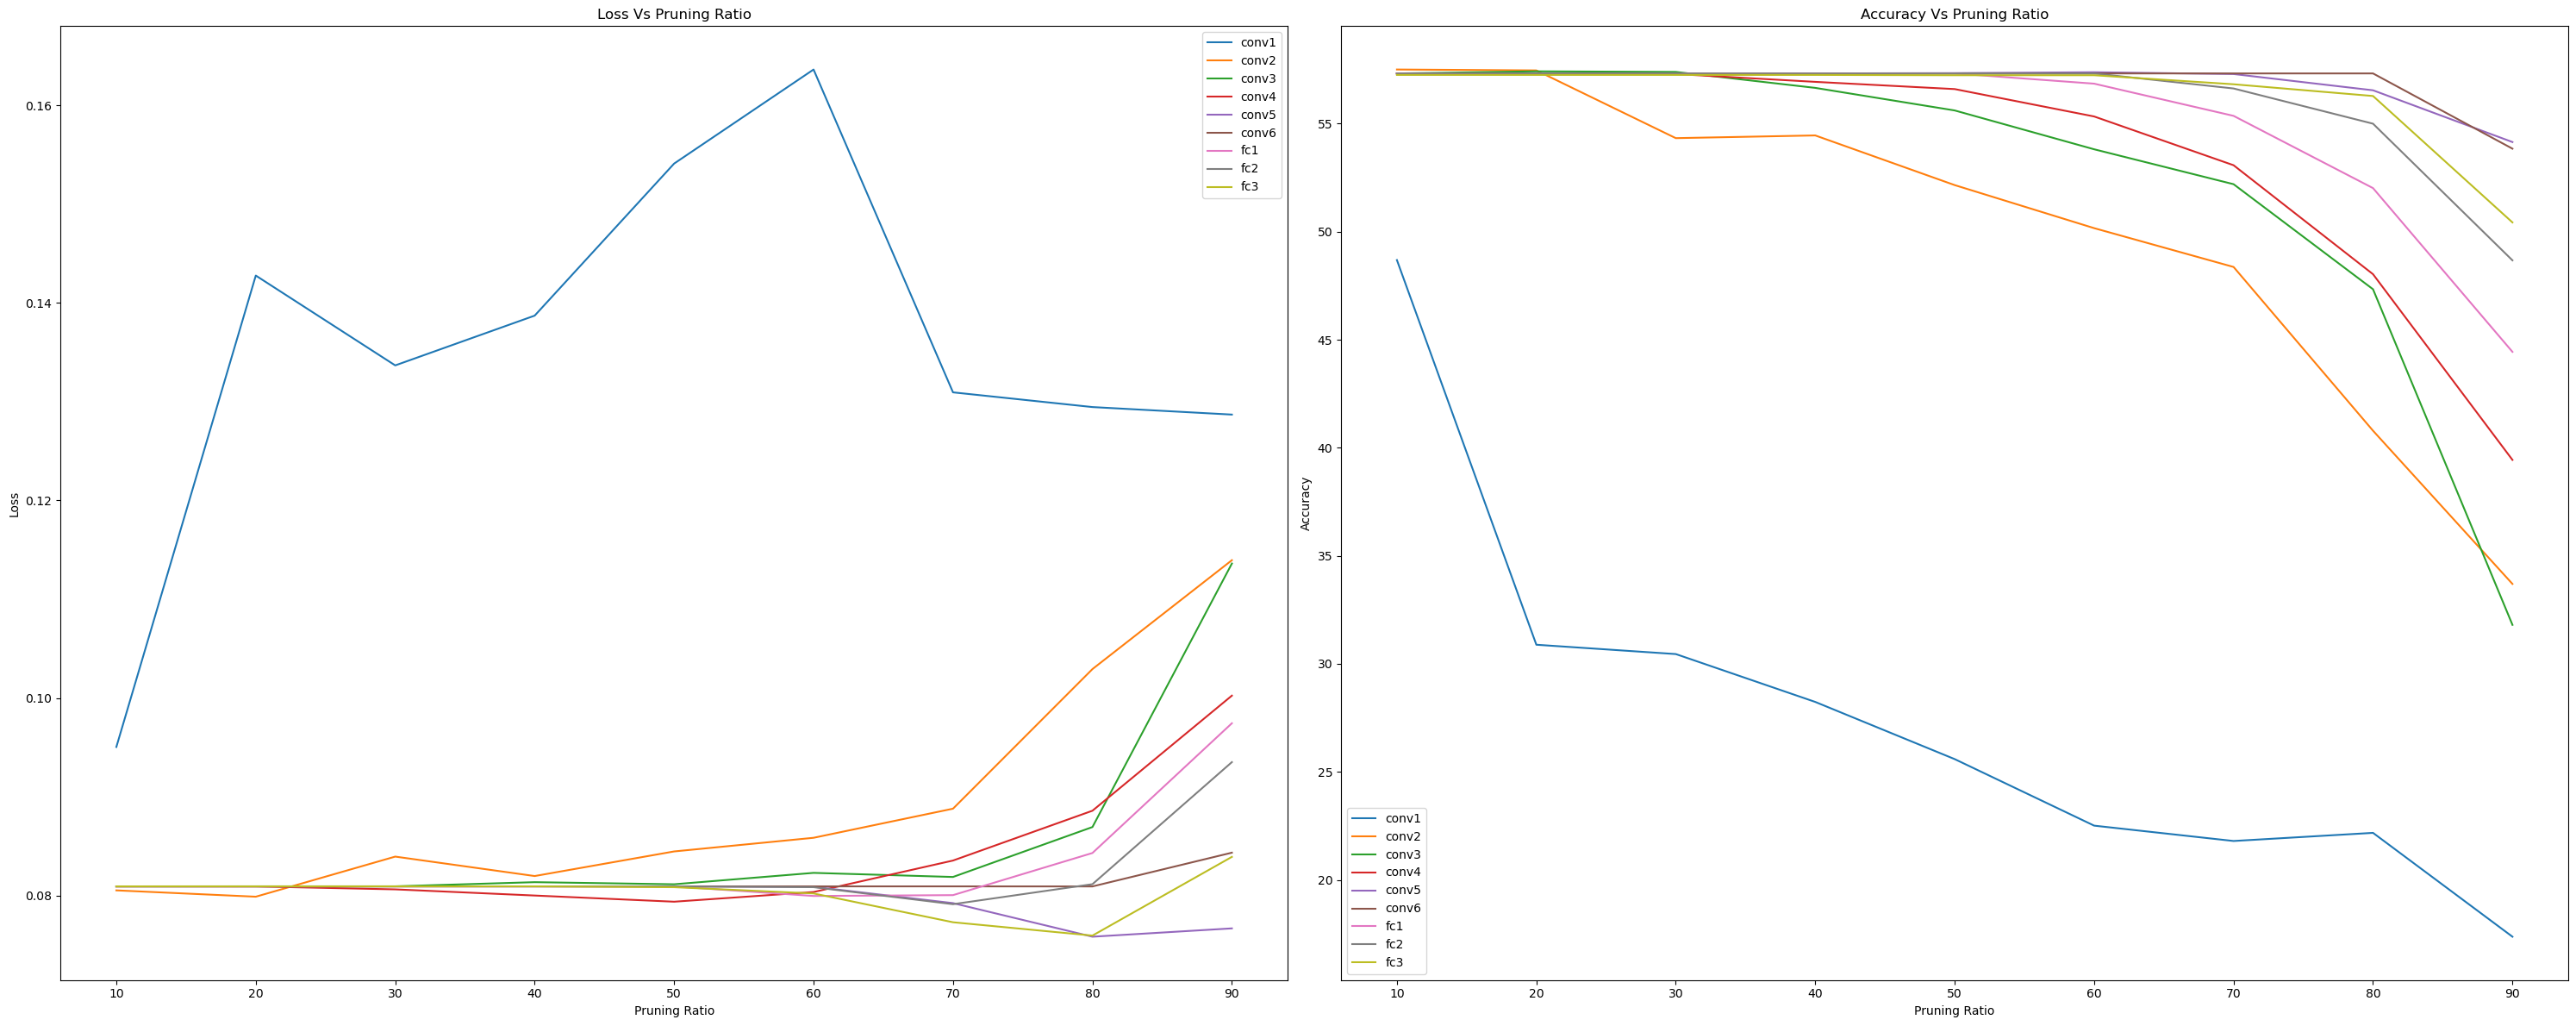

In [ ]:
with open("sensitivity.pkl", "rb") as file:
    layer_sensitivity = pickle.load(file)
fig, axs = plt.subplots(1, 2, figsize=(30, 12))


for (key, values) in layer_sensitivity.items():
    losses = [e[0] for e in values]
    acc = [e[1] for e in values]

    axs[0].plot(list(range(10, 100, 10)), losses, label = key)
    axs[1].plot(list(range(10, 100, 10)), acc, label=key)

axs[0].set_title("Loss Vs Pruning Ratio")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Pruning Ratio")

axs[1].set_title("Accuracy Vs Pruning Ratio")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Pruning Ratio")

axs[0].legend()
axs[1].legend()
plt.tight_layout()
fig.savefig("images/sensitivity_plot.png")

In [4]:
accuracy_threshold = 50
layer_to_pruning_threshold = {}

for (key, values) in layer_sensitivity.items():
    layer_to_pruning_threshold[key] = 0
    losses = [e[0] for e in values]
    acc = [e[1] for e in values]
    for i in range(len(acc)):
        if acc[i] > accuracy_threshold:
            layer_to_pruning_threshold[key] = i / 10
print(layer_to_pruning_threshold)


{'conv1': 0, 'conv2': 0.5, 'conv3': 0.6, 'conv4': 0.6, 'conv5': 0.8, 'conv6': 0.8, 'fc1': 0.7, 'fc2': 0.7, 'fc3': 0.8}


In [8]:
pruned_model = utils.BaseModel()
pruned_model.load_state_dict(torch.load("base_model/checkpoint_6.pth"))
pruned_model.to(utils.device)
example_inputs = torch.randn(1, 1, 96, 96).to(utils.device)


# 1. Importance criterion, here we calculate the L2 Norm of grouped weights as the importance score
imp = tp.importance.GroupMagnitudeImportance(p=2) 

# 2. Initialize a pruner with the model and the importance criterion
ignored_layers = []
for m in pruned_model.modules():
    if isinstance(m, torch.nn.Linear) and m.out_features == 7:
        ignored_layers.append(m) # DO NOT prune the final classifier!

pruning_ratio_dict = {}
for (key, value) in layer_to_pruning_threshold.items():
    pruning_ratio_dict[eval("pruned_model." + key)] = value

pruner = tp.pruner.BasePruner( # We can always choose BasePruner if sparse training is not required.
    pruned_model,
    example_inputs,
    importance=imp,
    pruning_ratio=0.0, 
    pruning_ratio_dict=pruning_ratio_dict,
    ignored_layers=ignored_layers,
    round_to=1,
)

# 3. Prune the model
base_macs, base_nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
tp.utils.print_tool.before_pruning(pruned_model) # or print(model)
pruner.step()
tp.utils.print_tool.after_pruning(pruned_model) # or print(model), this util will show the difference before and after pruning
macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print(f"MACs: {base_macs/1e9} G -> {macs/1e9} G, #Params: {base_nparams/1e6} M -> {nparams/1e6} M")

/var/tmp/ipykernel_921079/1769985354.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model.load_state_dict(torch.load("base_model/checkpoint_6.pth"))


BaseModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) => (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) => (conv3): Conv2d(32, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) => (conv4): Conv2d(102, 409, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) => (conv5): Conv2d(409, 409, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(2048, 4192, kernel_size=(3, 3), stride=(1, 1)) => (conv6): Conv2d(409, 838, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4192, out_features=2048, bias=True) =>

In [9]:
loss, acc = utils.test(pruned_model, testloader)
print("Post Pruning Finetuning Loss: {0} Accuracy: {1}\n".format(loss, acc))

Post Pruning Finetuning Loss: 0.1055983406781951 Accuracy: 36.765115631095014



In [ ]:
run = wandb.init(project="hpml-final", name="Pruned Model Finetuning")
params = utils.TrainingParams()
params.lr = 0.00001
params.checkpoint = True
params.dir_name = "pruned_model"
params.save_state_dict = False
utils.train(run, pruned_model, params, trainloader, testloader, 10)
run.finish()

wandb: Currently logged in as: ajf2243 (ajf2243-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Before Training

        Train Loss: 0.09885087989540849
        Train Acc: 42.5998815702393
        Test Loss: 0.1055983406781951
        Test Acc: 36.765115631095014    
        
[1,  1000] loss: 0.964
Epoch 1 Finished

            Train Loss: 0.04288364286232179
            Train Acc: 76.25483297920513
            Test Loss: 0.0769254811446492
            Test Acc: 56.85427695736974
            
[2,  1000] loss: 0.663
Epoch 2 Finished

            Train Loss: 0.03586433162933034
            Train Acc: 79.98188721306907
            Test Loss: 0.08085821547791233
            Test Acc: 57.244357759821675
            
[3,  1000] loss: 0.565
Epoch 3 Finished

            Train Loss: 0.03077297452888484
            Train Acc: 83.2979205127312
            Test Loss: 0.08557378413302548
            Test Acc: 57.07718027305656
            
[4,  1000] loss: 0.493
Epoch 4 Finished

            Train Loss: 0.02643139464783608
            Train Acc: 85.57246856386499
            Test Loss: 0.091